In [12]:
# import the python libraries we'll be using
import math
from pathlib import Path
from typing import Callable
import h5py
import gwpy
import lightning.pytorch as pl
from ml4gw import distributions, gw, waveforms, transforms, dataloading
from ml4gw.nn.resnet import ResNet1D
import matplotlib.pyplot as plt
import pyro
import torch
import bilby
import numpy as np
import pandas as pd

In [13]:
# instantiate some constants we'll use throughout the analysis

SAMPLE_RATE = 1024 # rate at which our timeseries is sampled in Hz
PSD_LENGTH = 8 # quantity of data (in seconds) used to calculate power spectral density
FDURATION = 1 # duration of time domain filter used to whiten data
IFOS = ["H1", "L1"] # interferometers we'll be using (LIGO Hanford and Livingston)
HIGHPASS = 32 # highpass filter frequency (Hz)
KERNEL_LENGTH = 0.5 # lenth of data (in seconds) passed to the interferometer
CONTEXT_DIM = 32 # dimension of compressed data that will be passed to the normalizing flow
FFTLENGTH = 2 # length of fft when estimating PSD
BATCHES_PER_EPOCH = 200 # number of batches seen before validation
MAX_EPOCHS = 30 # maximum number of training epochs
BATCH_SIZE = 256 # number of samples per training batch

In [18]:
from gwpy.timeseries import TimeSeries, TimeSeriesDict

# train validation and testing segments 
segments = [(1240872261, 1240892261), (1240892261, 1240906993), (1240914063, 1240919356)]

outdir = Path.cwd() / "data"
outdir.mkdir(exist_ok = True, parents = True)
fnames = ["train.hdf5", "val.hdf5", "test.hdf5"]
for segment, fname in zip(segments, out_fnames):
    print(f"Downloading {fname.split('.')[0]} segment, resampling to {SAMPLE_RATE} Hz and saving to {out_fname}")
    start, stop = segment
    data = TimeSeriesDict()
    for ifo in IFOS:
        data[ifo] = TimeSeries.fetch_open_data(ifo, start, stop).resample(SAMPLE_RATE)

    # write data using chunked storage which
    # makes dataloading quicker!
    with h5py.File(outdir / fname, "w") as f:
        data.write(
            f,
            format="hdf5",
            chunks=(131072,),
            compression=None,
        )

In [4]:
# helper object for generating samples from
# a prior defined for our waveform parameters
class ParameterSampler(torch.nn.Module):
    def __init__(self, **parameters: Callable):
        super().__init__()
        self.parameters = parameters

    def forward(
        self,
        N: int,
        device: str = "cpu",
    ):
        parameters = {
            k: v.sample((N,)).to(device) for k, v in self.parameters.items()
        }
        return parameters


# define our prior; some distributions are defined in the
# torch.distributions module, others are taken from ml4gw.distributions;
# this prior is for a sine-Gaussian waveform - more on that below
prior = ParameterSampler(
    frequency = torch.distributions.Uniform(128, 512), # central frequency of sine wave
    quality = torch.distributions.Uniform(2, 100), # quality factor ( ~ number of cycles )
    hrss = distributions.LogUniform(1e-21, 5e-20), # root sum squared strain (amplitude of signal)
    phase = torch.distributions.Uniform(0, 2 * math.pi), # signal phase
    eccentricity = torch.distributions.Uniform(0, 1), # eccentricity: controls relative content of h+ and hx polarizations
    dec = distributions.Cosine(), # declination (sky localization)
    psi = torch.distributions.Uniform(0, math.pi), # polarization angle
    phi = torch.distributions.Uniform(-math.pi, math.pi) # phi (sky localization)
)

# number of parameters inference is being performed on
NUM_PARAMS = len(prior.parameters.keys())
INFERENCE_PARAMS = list(prior.parameters.keys())

In [5]:
class DataLoader(pl.LightningDataModule):
    """
    PyTorch lightning DataModule object that produces
    data that is passed through the neural network for
    training and validation

    See https://lightning.ai/docs/pytorch/stable/data/datamodule.html
    """
    def __init__(
        self,
        ifos: list[str],
        sample_rate: float,
        psd_length: float,
        fduration: float,
        kernel_length: float,
        highpass: float,
        fftlength: float,
        batches_per_epoch: float,
        batch_size: float,
        num_params: int,
    ):

        # set attributes
        super().__init__()
        self.ifos = ifos
        self.sample_rate = sample_rate
        self.psd_length = psd_length
        self.fduration = fduration
        self.kernel_length = kernel_length
        self.fftlength = fftlength
        self.highpass = highpass
        self.batch_size = batch_size
        self.batches_per_epoch = batches_per_epoch

        # set the prior that we defined above
        self.prior = prior
        self.num_params = num_params


    """
    Define some helper properties
    """

    @property
    def kernel_size(self):
      """
      The quantity of data (in seconds) actually analyzed by
      the neural network
      """
      return int(self.kernel_length * self.sample_rate)

    @property
    def window_size(self):
        """
        The quantity of data (in seconds) before whitening is applied
        and corrupted data is removed
        """
        return self.kernel_size + int(self.fduration * self.sample_rate)

    @property
    def psd_size(self):
        """
        The quantity of data (in seconds) used for psd estimation
        """
        return int(self.psd_length * self.sample_rate)


    @property
    def data_fnames(self):
        home = (Path.cwd() / "ztf_data").iterdir()
        return sorted(home)

    @property
    def datadir(self):
        """
        Return path to the strain data files we unzipped
        and resampled above
        """
        return Path.cwd() / "ztf_data"


    @property
    def train_fnames(self):
      """
      The strain segment we'll be using to train the model;
      """
      #return [self.data_fnames[0]]
      return [self.datadir / "train.hdf5"]

    @property
    def val_fnames(self):
      """
      The strain segment we'll be using to validate the model
      """
      #return [self.data_fnames[-1]]
      return [self.datadir / "val.hdf5"]

    @property
    def device(self):
        """
        Find the device that the corresponding lightning module
        is on so that we can transfer any on-device modules to the correct device
        """
        return self.trainer.lightning_module.device


    """
    The below methods are all PyTorch Lightning "hooks" or properties
    used explicitly by the lightning library to control the DataModule.

    I've linked the relevant documentation for each in the docstring
    """

    def setup(self, stage):
        """
        Lightning hook for initializing modules and properties of
        the dataset on each device

        See https://lightning.ai/docs/pytorch/stable/data/datamodule.html#setup
        """

        # get the interferometer orientations and global positions
        # so that we can project waveforms onto the interferometers;
        tensors, vertices = gw.get_ifo_geometry(*self.ifos)

        self.tensors = tensors.to(self.device)
        self.vertices = vertices.to(self.device)

        # define torch module that will generate waveforms
        self.sine_gaussian = waveforms.SineGaussian(self.sample_rate, (self.fduration + self.kernel_length)).to(self.device)

        # define torch modules for calculating PSD and performing whitening on GPU
        self.spectral_density = transforms.SpectralDensity(
            self.sample_rate, self.fftlength, average="median", fast=True
        ).to(self.device)

        self.whitener = transforms.Whiten(self.fduration, self.sample_rate, highpass=self.highpass).to(self.device)

        # define and fit a standard scaler that will scale our parameters
        # to be mean 0 and unit variance, which makes it easier for the network to learn
        scaler = transforms.ChannelWiseScaler(self.num_params).to(self.device)
        parameters = self.prior(10_000, device = self.device)
        parameters = torch.row_stack(list(parameters.values()))
        scaler.fit(parameters)
        self.scaler = scaler


    def train_dataloader(self):
        """
        PyTorch Lightning Dataloader used for training

        See https://lightning.ai/docs/pytorch/stable/data/datamodule.html#train-dataloader
        """
        # define our training dataset, which will
        # randomly load windows of strain data from disk
        dataset = dataloading.Hdf5TimeSeriesDataset(
            self.train_fnames,
            channels=self.ifos,
            batch_size=self.batch_size,
            kernel_size=int(self.window_size + self.psd_size),
            batches_per_epoch=self.batches_per_epoch,
            coincident=False,
        )

        pin_memory = isinstance(
            self.trainer.accelerator, pl.accelerators.CUDAAccelerator
        )

        # wrap our dataset in a torch DataLoader to
        # take advantage of torch's multiprocessing
        dataloader = torch.utils.data.DataLoader(
            dataset, num_workers=3, pin_memory=pin_memory
        )
        return dataloader

    def val_dataloader(self):
        """
        PyTorch Lightning Dataloader used for validation

        See https://lightning.ai/docs/pytorch/stable/data/datamodule.html#val-dataloader
        """
        dataset = dataloading.Hdf5TimeSeriesDataset(
            self.val_fnames,
            channels=self.ifos,
            batch_size=self.batch_size,
            kernel_size=int(self.window_size + self.psd_size),
            batches_per_epoch=self.batches_per_epoch,
            coincident=False,
        )

        pin_memory = isinstance(
            self.trainer.accelerator, pl.accelerators.CUDAAccelerator
        )

        dataloader = torch.utils.data.DataLoader(
            dataset, num_workers=3, pin_memory=pin_memory
        )
        return dataloader


    def on_after_batch_transfer(self, batch, _):
        """
        PyTorch lightning "hook" for performing any
        data processing that can be accelerated by the GPU;

        For our use case, we will do all the following on the GPU

        1. Generate waveforms
        2. Inject waveforms into background strain
        3. Calculate PSD's
        4. Whiten the injections


        See https://lightning.ai/docs/pytorch/stable/data/datamodule.html#on-after-batch-transfer
        """


        # unpack the raw GW strain data that has been loaded onto the GPU
        [batch] = batch

        # generate waveforms (on GPU) and inject them into the data!
        num_signals = batch.shape[0]
        waveforms, parameters = self.generate_waveforms(num_signals)
        batch = self.inject(batch, waveforms, parameters)

        return batch

    """
    Non-Lightning specific helper functions for generating waveforms
    and adding them into the interferometers
    """

    # `@torch.no_grad()` let's torch know that we won't be using
    # gradients for back propogation, so
    # turn off gradient tracking to save memory
    @torch.no_grad()
    def inject(self, X, waveforms, parameters):

        # break off "background" from target kernel and compute its PSD
        # (in double precision since our scale is so small)
        background, X = torch.split(X, [self.psd_size, self.window_size], dim=-1)
        psd = self.spectral_density(background.double())


        # inject the waveforms into the data
        X = X + waveforms

        # whiten the injections with the psd
        X = self.whitener(X, psd)


        # scale parameters
        scaled = self.scale(parameters)


        return X, scaled


    @torch.no_grad()
    def generate_waveforms(self, batch_size):

        # sample waveform parameters
        # (both intrinsic and extrinsic) from the prior
        parameters = self.prior(batch_size, device = self.device)

        # pop out the extrinsic parameters into their own dictionary
        extrinsic = {}
        for parameter in ["phi", "dec", "psi"]:
            extrinsic[parameter] = parameters.pop(parameter)


        # generate raw cross and plus polarizations
        # from just the intrinsic parameters
        cross, plus = self.sine_gaussian(**parameters)

        # project waveforms onto the detectors
        # using the sampled extrinsic sky parameters
        waveforms = gw.compute_observed_strain(
          extrinsic['dec'],
          extrinsic['psi'],
          extrinsic['phi'],
          self.tensors,
          self.vertices,
          self.sample_rate,
          cross=cross,
          plus=plus,
        )


        # add back in the extrinsic parameters
        parameters.update(extrinsic)

        parameters = [
            torch.Tensor(parameters[k]) for k in self.prior.parameters.keys()
        ]
        parameters = torch.vstack(parameters).T

        # return the waveforms and parameters
        return waveforms, parameters


    def scale(self, parameters, reverse: bool = False):
        """
        Apply standard scaling to the parameters
        """
        parameters = parameters.transpose(1, 0)
        scaled = self.scaler(parameters, reverse=reverse)
        scaled = scaled.transpose(1, 0)
        return scaled

In [6]:
import torch
import torch.distributions as dist
from pyro.distributions import ConditionalTransformedDistribution
from pyro.distributions.conditional import ConditionalComposeTransformModule
from pyro.distributions.transforms import ConditionalAffineAutoregressive
from pyro.nn import ConditionalAutoRegressiveNN, PyroModule

class NormalizingFlow(PyroModule):
    """
    A torch.nn.Module that represents a normalizing flow
    """
    def __init__(
        self,
        num_params: int,
        hidden_features: int = 50,
        num_transforms: int = 3,
        num_blocks: int = 2,
        activation: torch.nn.modules.activation = torch.nn.Tanh(),
    ):

        super().__init__()
        self.num_params = num_params
        self.hidden_features = hidden_features
        self.num_blocks = num_blocks
        self.num_transforms = num_transforms
        self.activation = activation

        # register these as buffers so the
        # distributions are moved to the correct device
        self.register_buffer("mean", torch.zeros(self.num_params))
        self.register_buffer("std", torch.ones(self.num_params))

        # setup a trainable embedding network that will compress the data
        # to a lower dimension more manageable computationally for the flow;
        # Here we use a convolutional neural network
        self.embedding = ResNet1D(len(IFOS), layers = [2, 2], classes=CONTEXT_DIM)

        # build the sequence of invertible flow transforms
        self.transforms = self.build_transforms()

    def transform_block(self):
        """Returns single autoregressive transform"""
        arn = ConditionalAutoRegressiveNN(
            self.num_params,
            CONTEXT_DIM,
            self.num_blocks * [self.hidden_features],
            nonlinearity=self.activation,
        )
        return ConditionalAffineAutoregressive(arn)

    def distribution(self):
        """Returns the base distribution for the flow"""
        return dist.Normal(
            self.mean,
            self.std,
        )

    def flow(self) -> ConditionalTransformedDistribution:
        return ConditionalTransformedDistribution(
            self.distribution(), self.transforms
        )

    def build_transforms(self):
        """Compose multiple transforms into a 'flow' """
        transforms = []
        for _ in range(self.num_transforms):
            transform = self.transform_block()
            transforms.extend([transform])
        return ConditionalComposeTransformModule(transforms)

    def log_prob(self, x, context):
        """
        Return the networks approximate estimate of the
        log likelihood of the data conditioned on the context
        """
        embedded_context = self.embedding(context)
        return self.flow().condition(embedded_context).log_prob(x)


    def sample(self, n: int, context):
        """
        Produce posterior samples from the normalizing flow
        """

        embedded_context = self.embedding(context)
        n = [n] if isinstance(n, int) else n
        return self.flow().condition(embedded_context).sample(n)

In [7]:
class PlotCallback(pl.Callback):
    # define a callback that will be run when training begins
    def on_train_start(self, trainer, pl_module):
        datamodule = trainer.datamodule
        # sample a batch of strain data from our dataloader
        [batch] = next(iter(datamodule.train_dataloader()))
        batch = batch.to(trainer.datamodule.device)
        # perform on the on-device injections
        num_signals = batch.shape[0]
        waveforms, parameters = datamodule.generate_waveforms(num_signals)
        strain, parameters = datamodule.inject(batch, waveforms, parameters)


        strain = strain.detach().cpu().numpy()
        plt.plot(strain[0][0], label = "Hanford")
        plt.plot(strain[0][1], label = "Livingston")

        plt.xlabel("Time (number of samples)")
        plt.ylabel("Whitened Strain")
        plt.title("Example data")
        plt.legend()
        plt.show()

In [8]:
class SBIModule(pl.LightningModule):
    """
    PyTorch lightning LightningModule that configures how the neural network
    processes data in the training and validation loops, the optimizer used
    to perform gradient descent, and any learning rate schedulers.

    See https://lightning.ai/docs/pytorch/stable/common/lightning_module.html#lightningmodule
    """
    def __init__(
        self,
        learning_rate: float,
        weight_decay: float = 0.0,

    ):
        super().__init__()

        # instantiate the flow architecture
        # we are going to train
        self.model = NormalizingFlow(NUM_PARAMS)
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay


    def forward(self, strain, parameters) -> torch.Tensor:
        # return the negative log likelihood to minimize
        return -self.model.log_prob(parameters, context=strain)

    def training_step(self, batch, _):
        """
        Lightning hook that defines how we process a training batch;
        Should return some measure of 'loss' that we can call
        .backward() on to update the parameters of the normalizing
        """
        strain, parameters = batch
        loss = self(strain, parameters).mean()
        self.log(
            "train_loss",
            loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            sync_dist=False,
            logger=True,
        )
        return loss

    def validation_step(self, batch, _):
        """
        Lightning hook that defines how we process a validation batch;
        """
        strain, parameters = batch
        loss = self(strain, parameters).mean()
        self.log(
            "valid_loss",
            loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            sync_dist=True,
            logger=True,
        )
        return loss

    def configure_callbacks(self):
        """
        Lightning hook for setting up callbacks;
        Here we just use PlotCallback defined above and
        a builting ModelCheckpoint callback for saving model weight
        checkpoints

        """
        chkpt = pl.callbacks.ModelCheckpoint(monitor="valid_loss", mode="min")
        return [PlotCallback(), chkpt]


    def configure_optimizers(self):

        # pass the optimizer the model parameters to optimize
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay,
        )

        # setup a learning rate scheduler that will
        # decrease the learning rate if the validation loss doesnt improve
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "monitor": "valid_loss"},
        }

In [9]:
# instantiate our LightningModule and DataModule
model = SBIModule(learning_rate=1e-4)

dataloader = DataLoader(
    IFOS,
    SAMPLE_RATE,
    PSD_LENGTH,
    FDURATION,
    KERNEL_LENGTH,
    HIGHPASS,
    FFTLENGTH,
    BATCHES_PER_EPOCH,
    BATCH_SIZE,
    NUM_PARAMS
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
The following callbacks returned in `LightningM

Sanity Checking: |                                                                                            …

/opt/env/lib/python3.9/site-packages/lightning/pytorch/utilities/data.py:121: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Training: |                                                                                                   …

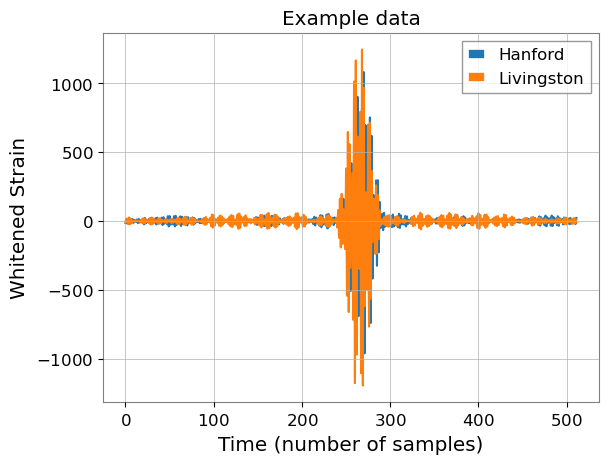

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

Validation: |                                                                            | 0/? [00:00<?, ?it/s…

/opt/env/lib/python3.9/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [10]:
# instantiate a PyTorch lightning Trainer object
trainer = pl.Trainer(max_epochs=MAX_EPOCHS)

# train! The fit command will run through the training step and validation step iteratively
# until max_epochs (or an early stopping condition) is reached
trainer.fit(model, dataloader)

In [ ]:
# now let's test out the model!

class DataLoaderWithTest(DataLoader):
    def test_dataloader(self):
        # TODO: implement the test data_loader
        # HINT: this should be very similar to the
        # train_dataloader and val_dataloader above -
        # recall that we have a test.hdf5 file!

        # Double HINT: use a batch_size of 1,
        # since model.sample can only take
        # one element at a time
        dataset = dataloading.Hdf5TimeSeriesDataset(
            self.train_fnames,
            channels=self.ifos,
            batch_size=1,
            kernel_size=int(self.window_size + self.psd_size),
            batches_per_epoch=10,
            coincident=False,
        )

        pin_memory = isinstance(
            self.trainer.accelerator, pl.accelerators.CUDAAccelerator
        )

        # wrap our dataset in a torch DataLoader to
        # take advantage of torch's multiprocessing
        dataloader = torch.utils.data.DataLoader(
            dataset, num_workers=1, pin_memory=pin_memory
        )
        return dataloader


class SBIModuleWithTest(SBIModule):
    def on_test_epoch_start(self):
        self.test_results = []
        self.idx = 0

    def test_step(self, batch, _):
        strain, parameters = batch

        samples = self.model.sample(
            1000, context=strain
        )

        # descale the parameters back to their physical values
        descaled = self.trainer.datamodule.scale(samples, reverse=True)
        parameters = self.trainer.datamodule.scale(parameters, reverse=True)

        result = self.cast_as_bilby_result(
            descaled.cpu().numpy(),
            parameters.cpu().numpy()[0],
        )

        self.test_results.append(result)


    def on_test_epoch_end(self):
        bilby.result.make_pp_plot(
            self.test_results,
            save=True,
            filename=self.outdir / "pp-plot.png",
            keys=self.inference_params,
        )




    def cast_as_bilby_result(
        self,
        samples: np.ndarray,
        truth: np.ndarray,
    ):
        """Cast posterior samples as Bilby Result object
        for ease of producing corner and pp plots

        Args:
            samples: posterior samples (1, num_samples, num_params)
            truth: true values of the parameters  (1, num_params)
            priors: dictionary of prior objects
            label: label for the bilby result object

        """

        injection_parameters = {
            k: float(v) for k, v in zip(list(prior.keys()), truth)
        }

        # create dummy prior with correct attributes
        # for making our results compatible with bilbys make_pp_plot
        priors = {
            param: bilby.core.prior.base.Prior(latex_label=param)
            for param in self.inference_params
        }
        posterior = dict()
        for idx, k in enumerate(self.inference_params):
            posterior[k] = samples.T[idx].flatten()
        posterior = pd.DataFrame(posterior)

        return bilby.result.Result(
            label="PEModel",
            injection_parameters=injection_parameters,
            posterior=posterior,
            search_parameter_keys=list(prior.keys()),
            priors=priors,
        )